# PRUEBA DE SIMULACIÓN - RETORNO A CLASES
### Alejandro Enríquez 
### Ingeniería en Ciencias de la Computación
### 10mo Ciclo

Objetivo: considerando los datos oficiales del ministerio de educación, obtener de una institución educativa la cantidad de estudiantes y docentes que existen, para obtener una simulación que mantenga las siguientes consideraciones.

- Considerar solo una institución
- El 90% de los docentes podrán volver, ya que están vacunados.
- El 5% al 10% de los estudiantes no podrán volver
- Despues de 30 días se realiza una prueba covid al 10% de los estudiantes. 2% son positivos. Si es positivo se cierra todo el curso
- La jornada estudiantil es de 6 horas
- Tienen un receso de 30 minutos, donde el foco de contagio es del 2%

Se debe obtener como resultados:

- Animación 2D/3D
- Cuantos contagios a fin de mes
- Cursos cerrados
- Entrada y salida de docentes a fin de mes

Generar gráficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuesta

In [1]:
# Imports
import simpy
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
random.seed(76)

In [2]:
# Cargar los datos
data = pd.read_excel('data.xlsx')
institucion = data[245:246]
institucion

,PARROQUIA,CODIGO_PARROQUIA,NOMBRE,CODIGO_INSTITUCION,TIPO_EDUCACION,SOSTENIMIENTO,ZONA,MODALIDAD,DOCENTES,TOTAL_ESTUDIANTES
245,SAN SEBASTIAN,10111,MADRID,01H00338,Educación Regular,Particular,UrbanaINEC,Presencial,13,172


In [3]:
# Procesamiento de los datos
DOCENTES = round((int(institucion['DOCENTES']*90)/100))
DOCENTES_INICIO = DOCENTES
ESTUDIANTES = round((int(institucion['TOTAL_ESTUDIANTES'])*random.randint(90,100))/100)
JORNADA = 360
TIEMPO = 60
RECESO = 30
EST_AULA = round(ESTUDIANTES/DOCENTES)
FOCO_CONTAGIO = 2

contagios = 0
cursos_cerrados = 0
es_docentes = 0
periodo = 0

proceso = pd.DataFrame(columns=['dia','total_cursos','cursos_cerrados','retorno_docente'])

In [4]:
# Clase
class Retorno(object):
    def __init__(self, environment, num_docentes, num_estudiantes):
        self.env = environment
        self.docentes = simpy.Resource(environment, num_docentes)
        self.estudiantes = num_estudiantes
        #self.accion = env.process(self.clases())
        
    def clases(self):
        global periodo
        global contagios
        print(periodo)
        try:
            if periodo == 1:
                print('Inicia el día a las: %.2f.' % env.now)
                yield self.env.timeout(JORNADA/2)
                print('Inicia el recreo a las: %.2f.' % env.now)
                print('Se realizan las pruebas PCR')
                contagio = FOCO_CONTAGIO + random.randint(0,2)
                if(contagio < random.randint(1,100)):
                    pr = round((EST_AULA*contagio)/100)
                    print("Se hace la prueba a",EST_AULA," estudiantes y salen",pr ,"contagiados ")
                    if pr == 1:
                        self.interrumpir()
                        contagios += 1
                else:
                    yield self.env.timeout(JORNADA/2)
            else:
                print('Inicia el día a las: %.2f.' % env.now)
                yield self.env.timeout(JORNADA/2)
                print('Inicia el recreo a las: %.2f.' % env.now)
                yield self.env.timeout(RECESO)
                print('Termina el recreo y se reinician las clases a las %.2f.' % env.now)
                yield self.env.timeout(JORNADA/2)
                print('Finaliza el día a las: %.2f.' % env.now)
        except simpy.Interrupt:
            DOCENTES = DOCENTES-1
            
    def interrumpir(self):
        global DOCENTES
        global cursos_cerrados
        print('¡Se cierra la clase por contagio!')
        #self.accion.interrupt()
        DOCENTES = DOCENTES-1
        cursos_cerrados += 1

In [5]:
# Procesos
def llegada_estudiantes(env, retorno):
    with retorno.docentes.request() as docente:
        yield docente
        yield env.process(retorno.clases())
        
def ejecutar_simulacion(env, num_docentes, num_estudiantes):
    retorno = Retorno(env, num_docentes, num_estudiantes)
    yield env.process(llegada_estudiantes(env, retorno))

In [6]:
# Simulación 
print("Iniciando retorno a clases")

for i in range(TIEMPO):
    env = simpy.Environment()
    print("Las aulas disponibles del día ", i+1, " son: ", DOCENTES)
    #print("Las aulas disponibles son: ", DOCENTES)
    env.process(ejecutar_simulacion(env, DOCENTES, ESTUDIANTES))
    env.run(until=JORNADA)
    if i > 28:
        print("################### EMPIEZAN LAS PRUEBAS PCR ####################")
        periodo = 1
        
    con = 0
    if i % 18 == 0 and i>18:
        es_docentes += 1
        print("Pasaron 20 días")
        DOCENTES = DOCENTES + 1
    
    dia = [i+1, DOCENTES, cursos_cerrados, es_docentes]
    proceso.loc[len(proceso)] = dia
        
print("Contagios", contagios)
print("Cursos cerrados", cursos_cerrados)
print("Retorno de los Docentes", es_docentes)

proceso

        

Iniciando retorno a clases
Las aulas disponibles del día  1  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
Las aulas disponibles del día  2  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
Las aulas disponibles del día  3  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
Las aulas disponibles del día  4  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
Las aulas disponibles del día  5  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
Las aulas disponibles del día  6  son:  12
0
Inicia el día a las: 0.00.
Inicia el recreo a las: 180.00.
Termina el recreo y se reinician las clases a las 210.00.
L

,dia,total_cursos,cursos_cerrados,retorno_docente
0,1,12,0,0
1,2,12,0,0
2,3,12,0,0
3,4,12,0,0
4,5,12,0,0
5,6,12,0,0
6,7,12,0,0
7,8,12,0,0
8,9,12,0,0
9,10,12,0,0


In [7]:
data_temp = proceso.loc[proceso['dia'] == 36, :]
[int(data_temp['total_cursos']), int(data_temp['cursos_cerrados']), int(data_temp['retorno_docente'])]

[12, 0, 0]

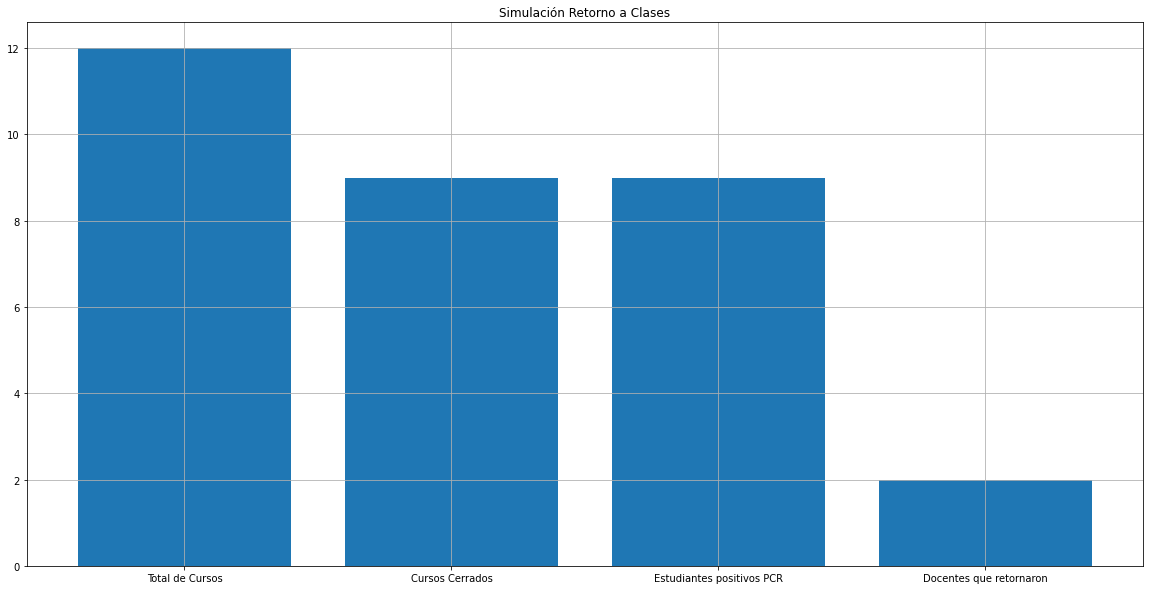

In [8]:
# Gráfica y resultados
fig = plt.figure(figsize=(20,10))

labels = ['Total de Cursos', 'Cursos Cerrados', 'Estudiantes positivos PCR', 'Docentes que retornaron']
datos = [DOCENTES_INICIO, cursos_cerrados, contagios, es_docentes]
plt.grid()
plt.title('Simulación Retorno a Clases')
plt.bar(labels, datos)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


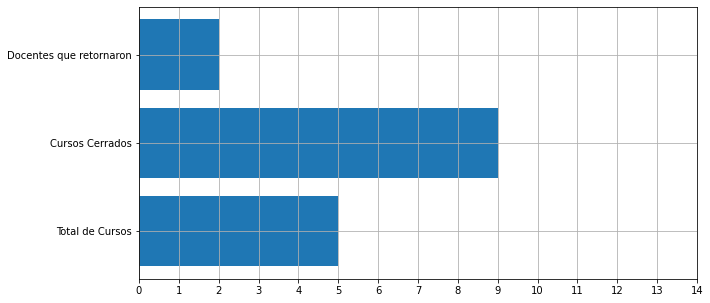

In [13]:
dias = proceso['dia'].unique()
labels = ['Total de Cursos', 'Cursos Cerrados', 'Docentes que retornaron']

font = {
    'weight': 'normal',
    'size'  :  40,
    'color': 'black'
}

fig, ax = plt.subplots(figsize=(10,5))
label = ax.text(0.5, 0.5, 'Día '+str(dias[0]),
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes,
            fontdict=font)

def animacion(i):
    day = dias[i]
    data_temp = proceso.loc[proceso['dia'] == day, :]
    ax.clear()
    ax.barh(labels, [int(data_temp['total_cursos']), int(data_temp['cursos_cerrados']), int(data_temp['retorno_docente'])]) 
    ax.set_xticks(np.arange(0,15,1)) 
    label.set_text('Día '+str(day))
    ax.set_label(label)
    plt.grid(True)
    
anim = animation.FuncAnimation(fig, animacion, frames = len(dias))

anim.save('Prueba1.gif')

# Conclusiones

Tras realizar la simulación se obtuvieron como resultado la cantidad de cursos cerrados, el total de cursos disponibles en relación a los cursos que hay inicialmente y los docentes que han retornado a sus actividades normales. 

La animación se realizó utilizando animation de matplotlib, dando como resultado un gif que esta adjunto a este documento.